<a href="https://colab.research.google.com/github/aadi-mishra/deepLearningProjects/blob/main/cryptocurrencyPricePredictionUsingRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset contains time series data of Bitcoin cash, bitcoin, etherium and litecoin provided by Harrison from his [website](https://pythonprogramming.net/). This is a code along from his tutorial.

In [4]:
!git clone https://github.com/aadi-mishra/deepLearningProjects.git

Cloning into 'deepLearningProjects'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 57 (delta 23), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [5]:
%cd deepLearningProjects/data/crypto_data/

/content/deepLearningProjects/data/crypto_data


In [6]:
import time
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from sklearn import preprocessing
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

### Some data wrangling

In [7]:
# df = pd.read_csv('LTC-USD.csv', names=["time", "low", "high", "open", "close", "volume"])
# print(df.head(10))


def classify(current, future):
  if float(future) > float(current):
    return 1  # buy
  else:
    return 0  # don't buy 

main_df = pd.DataFrame()
ratios = ["BTC-USD", "LTC-USD", "ETH-USD", "BCH-USD"]

# Merging dataframe["close", "vo lume"] columns for each currency with reference to time 
for ratio in ratios:
  dataset = f"{ratio}.csv"
  df = pd.read_csv(dataset, names=["time", "low", "high", "open", "close", "volume"])
  

  df.rename(columns={"close":f"{ratio}_close", "volume":f"{ratio}_volume"}, inplace=True)
  df.set_index("time", inplace=True)
  df = df[[f"{ratio}_close", f"{ratio}_volume"]]
  print(df.head(10))
  
  if len(main_df) == 0:
    main_df = df
  else:
    main_df = main_df.join(df)

#print(main_df.head(10))

for c in main_df.columns:
  print(c)

print(main_df.head(10))




            BTC-USD_close  BTC-USD_volume
time                                     
1528968660    6489.549805        0.587100
1528968720    6487.379883        7.706374
1528968780    6479.410156        3.088252
1528968840    6479.410156        1.404100
1528968900    6479.979980        0.753000
1528968960    6480.000000        1.490900
1528969020    6477.220215        2.731950
1528969080    6480.000000        2.174240
1528969140    6479.990234        0.903100
1528969200    6478.660156        3.258786
            LTC-USD_close  LTC-USD_volume
time                                     
1528968660      96.580002        9.647200
1528968720      96.660004      314.387024
1528968780      96.570000       77.129799
1528968840      96.500000        7.216067
1528968900      96.389999      524.539978
1528968960      96.519997       16.991997
1528969020      96.440002       95.524078
1528969080      96.470001      175.205307
1528969140      96.400002       43.652802
1528969200      96.400002        8

### Now we have sequential data, but we also need targets

In [8]:
SEQ_LEN = 60 # minutes of pricing data to predict ahead
FUTURE_PERIOD_PREDICT = 3 #minutes
RATIO_TO_PREDICT = "LTC-USD"  # Let's just do this one for now

main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT) # We shift the rows n steps up so the future column corresponds to n steps ahead price wrt current 

print(main_df.head())

            BTC-USD_close  BTC-USD_volume  ...  BCH-USD_volume     future
time                                       ...                           
1528968660    6489.549805        0.587100  ...        5.675361  96.500000
1528968720    6487.379883        7.706374  ...       26.856577  96.389999
1528968780    6479.410156        3.088252  ...        1.124300  96.519997
1528968840    6479.410156        1.404100  ...        1.749862  96.440002
1528968900    6479.979980        0.753000  ...        1.680500  96.470001

[5 rows x 9 columns]


In [9]:
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future"]].head())

            LTC-USD_close     future
time                                
1528968660      96.580002  96.500000
1528968720      96.660004  96.389999
1528968780      96.570000  96.519997
1528968840      96.500000  96.440002
1528968900      96.389999  96.470001


In [10]:
main_df['target'] = list(map(classify,main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"] ))
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future", "target"]].head(10))

            LTC-USD_close     future  target
time                                        
1528968660      96.580002  96.500000       0
1528968720      96.660004  96.389999       0
1528968780      96.570000  96.519997       0
1528968840      96.500000  96.440002       0
1528968900      96.389999  96.470001       1
1528968960      96.519997  96.400002       0
1528969020      96.440002  96.400002       0
1528969080      96.470001  96.400002       0
1528969140      96.400002  96.400002       0
1528969200      96.400002  96.400002       0


### Preprocessing our data, since different currencies have differenr attributes.
* Normalize - scaling
* Balancing - Having equal no. of Buys and Sells in our dataset

#### Let's separate data for testing first, We cannot randomly shuffle and select data, rather we will select a chunk of time series data, preferably in the future for this use case.

In [11]:
times = sorted(main_df.index.values)  # get the times
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]  # get the last 5% of the times
validation_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%
validation_main_df.head()


,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,ETH-USD_close,ETH-USD_volume,BCH-USD_close,BCH-USD_volume,future,target
time,,,,,,,,,,
1534922100,6684.500000,0.969366,57.509998,66.463028,285.739990,194.228867,550.719971,5.058020,57.509998,0
1534922160,6684.500000,0.611018,57.509998,3.616516,285.730011,11.172032,550.710022,0.136300,57.509998,0
1534922220,6682.740234,1.121768,57.509998,13.260421,285.730011,1.411576,551.299988,75.830658,57.509998,0
1534922280,6682.660156,0.912729,57.509998,19.851404,285.739990,3.382381,551.299988,8.701156,57.500000,0
1534922340,6682.450195,0.334119,57.509998,17.104265,285.730011,0.429721,551.179993,9.790523,57.509998,0


In [12]:
# function to preprocess the data
def preprocess_df2(df):
  df = df.drop('future', 1) # We don't need future col anymore since we've already obtained target

  # Scaling our columns
  for col in df.columns:
    if col != "target":
      df[col] = df[col].pct_change() # Normalize the columns bases on percent change
      df.dropna(inplace=True)
      df[col] = preprocessing.scale(df[col].values)
  
  df.dropna(inplace=True)

  sequential_data = []
  prev_days = deque(maxlen = SEQ_LEN)
  
  for i in df.values:
    prev_days.append([n for n in i[:-1]])
    if prev_days == SEQ_LEN:
      sequential_data.append([np.array(prev_days), i[-1]])
  
  random.shuffle(sequential_data)

  buys = []
  sells = []

  for seq, target in sequential_data:
    if target == 0:
      sells.append([seq, target])
    elif target == 1:
      buys.append([seq, target])
  
  random.shuffle(buys)
  random.shuffle(sells)

  lower = min(len(buys), len(sells)) # Which series is shorter

  buys = buys[:lower]
  sells = sells[:lower]

  sequential_data = buys + sells

  random.shuffle(sequential_data)

  X = []
  y = []

  for seq, target in sequential_data:
    X.append(seq)
    y.aapend(target)

  return np.array(X), y

In [27]:
def preprocess_df(df):
    df = df.drop("future", 1)  # don't need this anymore.

    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] = df[col].pct_change()  # pct change "normalizes" the different currencies (each crypto coin has vastly diff values, we're really more interested in the other coin's movements)
            df.dropna(inplace=True)  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  # cleanup again... jic.


    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), y  # return X and y...and make X a numpy array!



In [28]:
train_x, train_y = preprocess_df(main_df)
val_x, val_y = preprocess_df(validation_main_df)

print(f"train data: {len(train_x)} validation: {len(val_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {val_y.count(0)}, buys: {val_y.count(1)}")

train data: 69188 validation: 3062
Dont buys: 34594, buys: 34594
VALIDATION Dont buys: 1531, buys: 1531


In [31]:
print(type(train_x), type(train_y), type(val_x), type(val_y))
train_y = np.asarray(train_y)
val_y = np.asarray(val_y)
print(type(train_x), type(train_y), type(val_x), type(val_y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [32]:
EPOCHS = 10
BATCH_SIZE = 64
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [33]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [34]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 128)           70144     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)              

In [36]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))


In [43]:
filepath = "RNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones


In [44]:
# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_x, val_y),
    callbacks=[tensorboard, checkpoint],
)

Epoch 1/10
1082/1082 [==============================] - 60s 56ms/step - loss: 0.6823 - accuracy: 0.5603 - val_loss: 0.6787 - val_accuracy: 0.5637


INFO:tensorflow:Assets written to: models/RNN_Final-01-0.564.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-01-0.564.model/assets


Epoch 2/10
1082/1082 [==============================] - 63s 58ms/step - loss: 0.6809 - accuracy: 0.5666 - val_loss: 0.6769 - val_accuracy: 0.5594


INFO:tensorflow:Assets written to: models/RNN_Final-02-0.559.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-02-0.559.model/assets


Epoch 3/10
1082/1082 [==============================] - 63s 58ms/step - loss: 0.6791 - accuracy: 0.5698 - val_loss: 0.6782 - val_accuracy: 0.5650


INFO:tensorflow:Assets written to: models/RNN_Final-03-0.565.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-03-0.565.model/assets


Epoch 4/10
1082/1082 [==============================] - 65s 60ms/step - loss: 0.6771 - accuracy: 0.5734 - val_loss: 0.6793 - val_accuracy: 0.5594


INFO:tensorflow:Assets written to: models/RNN_Final-04-0.559.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-04-0.559.model/assets


Epoch 5/10
1082/1082 [==============================] - 64s 60ms/step - loss: 0.6758 - accuracy: 0.5751 - val_loss: 0.6829 - val_accuracy: 0.5601


INFO:tensorflow:Assets written to: models/RNN_Final-05-0.560.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-05-0.560.model/assets


Epoch 6/10
1082/1082 [==============================] - 65s 60ms/step - loss: 0.6720 - accuracy: 0.5841 - val_loss: 0.6844 - val_accuracy: 0.5594


INFO:tensorflow:Assets written to: models/RNN_Final-06-0.559.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-06-0.559.model/assets


Epoch 7/10
1082/1082 [==============================] - 62s 57ms/step - loss: 0.6661 - accuracy: 0.5933 - val_loss: 0.6862 - val_accuracy: 0.5568


INFO:tensorflow:Assets written to: models/RNN_Final-07-0.557.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-07-0.557.model/assets


Epoch 8/10
1082/1082 [==============================] - 64s 60ms/step - loss: 0.6598 - accuracy: 0.6035 - val_loss: 0.6914 - val_accuracy: 0.5490


INFO:tensorflow:Assets written to: models/RNN_Final-08-0.549.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-08-0.549.model/assets


Epoch 9/10
1082/1082 [==============================] - 63s 59ms/step - loss: 0.6508 - accuracy: 0.6158 - val_loss: 0.6970 - val_accuracy: 0.5643


INFO:tensorflow:Assets written to: models/RNN_Final-09-0.564.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-09-0.564.model/assets


Epoch 10/10
1082/1082 [==============================] - 63s 59ms/step - loss: 0.6385 - accuracy: 0.6308 - val_loss: 0.7205 - val_accuracy: 0.5503


INFO:tensorflow:Assets written to: models/RNN_Final-10-0.550.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-10-0.550.model/assets


In [46]:
# Score model
score = model.evaluate(val_x, val_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
model.save("models/{}".format(NAME))

Test loss: 0.7205070853233337
Test accuracy: 0.5502939224243164


INFO:tensorflow:Assets written to: models/60-SEQ-3-PRED-1620737827/assets


INFO:tensorflow:Assets written to: models/60-SEQ-3-PRED-1620737827/assets


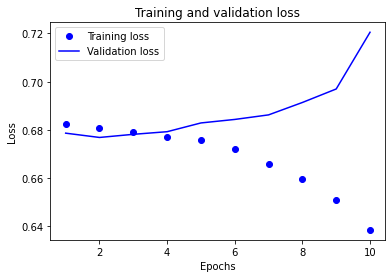

In [47]:

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

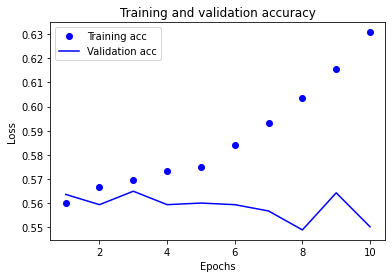

In [48]:

plt.clf()
acc_values = history_dict['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()